In [553]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
import cv2
import os
from moviepy.editor import VideoFileClip
from collections import deque


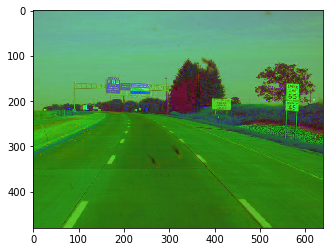

In [492]:
test1 = mpimg.imread('speed_sign5.jpg')
test1.shape
test2 = cv2.cvtColor(test1, cv2.COLOR_RGB2HLS)
plt.imshow(test2)

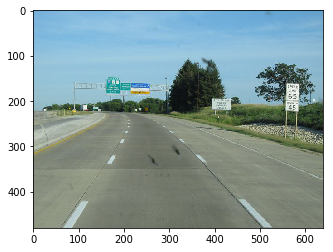

In [493]:
plt.imshow(test1)

In [494]:
test1.shape

(480, 640, 3)

# Color extraction and transformation

In [554]:
def select_rgb_white_yellow(image): 
    # white color mask
    lower = np.uint8([200, 200, 200])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image, lower, upper)
    # yellow color mask
    lower = np.uint8([190, 190,   0])
    upper = np.uint8([255, 255, 255])
    yellow_mask = cv2.inRange(image, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked = cv2.bitwise_and(image, image, mask = mask)
    return masked

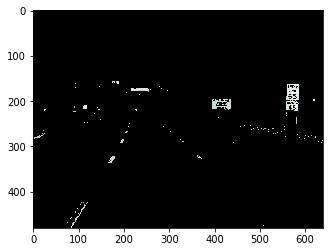

In [496]:
select_white_yellow1 = select_rgb_white_yellow(test1)
plt.imshow(select_white_yellow1)


In [555]:
def convert_hls(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

In [556]:
def select_white_yellow(image):
    converted = convert_hls(image)
    # white color mask
    lower = np.uint8([  0, 200,   0])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(converted, lower, upper)
    # yellow color mask
    lower = np.uint8([ 10,   0, 100])
    upper = np.uint8([ 40, 255, 255])
    yellow_mask = cv2.inRange(converted, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    return cv2.bitwise_and(image, image, mask = mask)


In [499]:
white_yellow_result = select_white_yellow(test1)

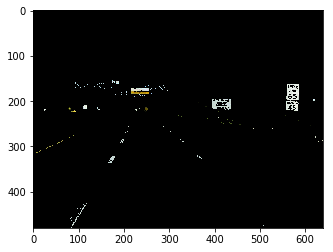

In [500]:
plt.imshow(white_yellow_result)

In [557]:
def convert_gray_scale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

In [502]:
gray_test1 = convert_gray_scale(white_yellow_result)

(480, 640)

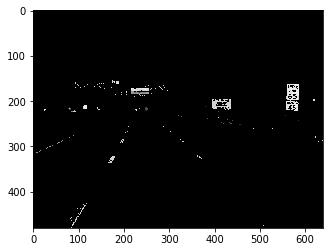

In [503]:
plt.imshow(gray_test1, cmap='gray')
gray_test1.shape

# Smoothing image

In [558]:
def our_filter(k):
    kernel = np.ones((k,k), np.float32)/(k*k)
    return kernel
# Using a 3*3 filter
smoothing_kernel = our_filter(6)
gray_test1.shape

(480, 640)

In [559]:
def padding_func(img,kernel):
    row = int(kernel.shape[0]/2)
    column = int(kernel.shape[1]/2)
    padded_img = np.pad(img,((row, row),(column, column)),mode='constant')
    return padded_img

In [506]:
padded_image = padding_func(gray_test1, smoothing_kernel)

In [507]:
padded_image.shape

(486, 646)

In [560]:
def smoothing(padded_image, image, kernel):
    m, n = kernel.shape  
    x, y = image.shape
    s,t = padded_image.shape
    new_image = np.zeros_like(image)
    for i in range(x):
        for j in range(y):
            sum = 0.0
            for p in range(m):
                for q in range(n):
                    sum = sum + (padded_image[i+p][j+q]*kernel[p][q])
            new_image[i][j] = sum
    return new_image

In [509]:
smoothed_test1_image = smoothing(padded_image, gray_test1, smoothing_kernel)

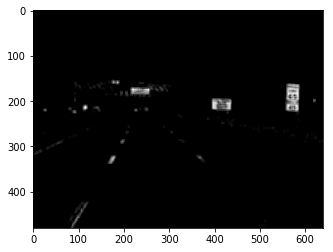

In [510]:
plt.imshow(smoothed_test1_image, cmap='gray')

# Sobel operator for edge detection

In [561]:
#we use a sobel operator for edge detection
def sobel(img, threshold, kernel):
    k = int(kernel/2)
    h,w = img.shape
    Gx = np.zeros((h,w))
    Gy = np.zeros((h,w))
    Tan = np.zeros((h,w))
    I=np.zeros((h,w))
    our_threshold=np.zeros((h,w))
    

    Gx_Filter=[[-1, 0, 1],[-2, 0, 2],[ -1, 0, 1]]
    Gy_Filter=[[-1, -2, -1],[0, 0, 0],[ 1, 2, 1]]

    for i in range(2,h-2):
        for j in range(2,w-2):
            block = img[i-k:i+k+1, j-k:j+k+1]
            res_gx = np.sum(np.multiply(block, Gx_Filter))
            res_gy = np.sum(np.multiply(block, Gy_Filter))
            intensity = math.sqrt(res_gx**2 + res_gy**2)
            Gx[i][j] = int(res_gx)
            Gy[i][j] = int(res_gy)
            Tan[i][j] = math.degrees(math.atan(res_gy/res_gx))
            I[i][j] = int(intensity)
            # I have set the threshold here
            if(I[i][j] > threshold):
                our_threshold[i][j] = 255
    return I, Gx, Gy, Tan, our_threshold

In [512]:
final_res, res_gx, res_gy, res_tan, thresh = sobel(smoothed_test1_image, 60,3)

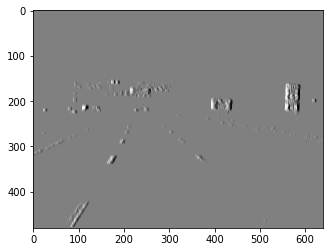

In [513]:
plt.imshow(res_gx, cmap = 'gray')


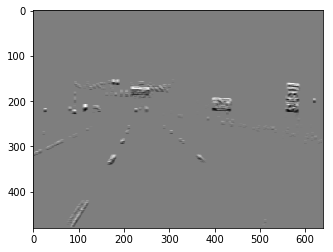

In [514]:
plt.imshow(res_gy, cmap = 'gray')


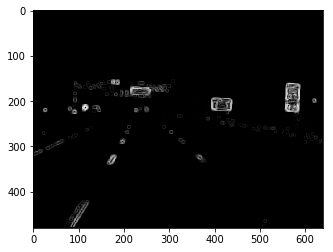

In [515]:
plt.imshow(final_res, cmap = 'gray')


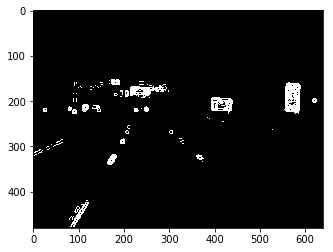

In [516]:
plt.imshow(thresh, cmap = 'gray')

# Region of Interest Selection

In [562]:
def filter_region(image, vertices):
    """
    Create the mask using the vertices and apply it to the input image
    """
    mask = np.zeros_like(image)
    if len(mask.shape)==2:
        cv2.fillPoly(mask, vertices, 255)
    else:
        cv2.fillPoly(mask, vertices, (255,)*mask.shape[2]) # in case, the input image has a channel dimension        
    return cv2.bitwise_and(image, mask)

In [563]:
def select_region(image):
    """
    It keeps the region surrounded by the `vertices` (i.e. polygon).  Other area is set to 0 (black).
    """
    # first, define the polygon by vertices
    rows, cols = image.shape[:2]
    bottom_left  = [cols*0.02, rows*0.99]
    top_left     = [cols*0.04, rows*0.03]
    bottom_right = [cols*0.99, rows*0.99]
    top_right    = [cols*0.6, rows*0.6]
    print(bottom_left, top_left, bottom_right, top_right)
    # the vertices are an array of polygons (i.e array of arrays) and the data type must be integer
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return filter_region(image, vertices)

In [465]:
roi_test1 = select_region(thresh)

[12.8, 475.2] [25.6, 14.399999999999999] [633.6, 475.2] [384.0, 288.0]


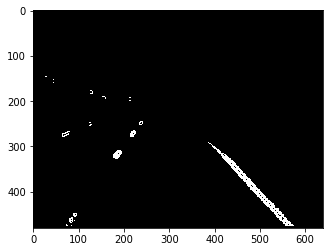

In [466]:
plt.imshow(roi_test1, cmap='gray')

# Hough transform for detecting lines

In [564]:
def getLength(startPoint,secondPoint):
    v1x=secondPoint[0]-startPoint[0]
    v1y=secondPoint[1]-startPoint[1]
    lenv=np.sqrt(v1x*v1x+v1y*v1y)
    return lenv

In [571]:
def hough_transform(img_bin, theta_res=1, rho_res=1, thresholdVotes=150, filterMultiple=30, thresholdPixels=0):
    nR,nC = img_bin.shape
    #print("Image shape is :" , nR, nC)
    theta = np.linspace(-90.0, 0.0, np.ceil(90.0/theta_res) + 1.0)
    theta = np.concatenate((theta, -theta[len(theta)-2::-1]))
    #print("Theta is :",theta)
    
    D = np.sqrt((nR - 1)**2 + (nC - 1)**2)
    #print("nR is: ",nR-1, " nC is : ",nC-1, "and D is :", D)
    
    q = np.ceil(D/rho_res)
    #print("Q is :",q)
    
    nrho = 2*q + 1
    #print("nrho(2Q+1) is :", nrho)
    
    rho = np.linspace(-q*rho_res, q*rho_res, nrho)
    #print("Rho is :",rho)
    
    #print("Len of rho is :",len(rho)," and Len of Theta is : ", len(theta))
    H = np.zeros((len(rho), len(theta)))
    print(H.shape)
    for rowIdx in range(nR):
        for colIdx in range(nC): 
            if img_bin[rowIdx, colIdx]:
                for thIdx in range(len(theta)):
                    rhoVal = colIdx*np.cos(theta[thIdx]*np.pi/180.0) + \
                      rowIdx*np.sin(theta[thIdx]*np.pi/180)
                    #print("Rho - RhoVal is :",rho - rhoVal)
                    rhoIdx = np.nonzero(np.abs(rho-rhoVal) == np.min(np.abs(rho-rhoVal)))[0]
                    #print(rhoIdx[0])
                    H[rhoIdx[0], thIdx] += 1
                    
    if filterMultiple>0:
        clusterDiameter=filterMultiple
        values=np.transpose(np.array(np.nonzero(H>thresholdVotes)))
        filterArray=[]
        filterArray.append(0)
        totalArray=[]
        for i in range (0, len(values)):
            if i in filterArray[1::]:
                continue
            tempArray=[i]
            for j in range (i+1, len(values)):
                if j in filterArray[1::]:
                    continue
                for k in range (0, len(tempArray)):
                    if getLength(values[tempArray[k]],values[j])<clusterDiameter:
                        filterArray.append(j)
                        tempArray.append(j)
                        break
            totalArray.append(tempArray)
        
        #leave the highest value in each cluster
        for i in range (0, len(totalArray)):
             for j in range (0, len(totalArray[i])):
                if j==0:
                    highest=H[values[totalArray[i][j]][0],values[totalArray[i][j]][1]]
                    ii=i
                    jj=j
                else:
                    if H[values[totalArray[i][j]][0],values[totalArray[i][j]][1]]>=highest:
                        highest=H[values[totalArray[i][j]][0],values[totalArray[i][j]][1]]
                        H[values[totalArray[ii][jj]][0],values[totalArray[ii][jj]][1]]=0
                        ii=i
                        jj=j
                    else:
                        H[values[totalArray[i][j]][0],values[totalArray[i][j]][1]]=0
                    
    return H, (np.where(H>thresholdVotes)[0]-q)*rho_res, theta[np.where(H>thresholdVotes)[1]]*np.pi/180.0
    #return rho, theta, H, q

In [547]:
H, r, t = hough_transform(roi_test1) 

(1599, 181)


In [572]:
def show_hough_line(img, accumulator, thetas, rhos):

    fig, ax = plt.subplots(1, 2, figsize=(10, 10))

    ax[0].imshow(img, cmap=plt.cm.gray)
    ax[0].set_title('Input image')
    ax[0].axis('image')

    ax[1].imshow(
        accumulator,
        extent=[-360, 360, rhos[-1], rhos[0]], cmap='gray')
    ax[1].set_aspect('equal', adjustable='box')
    ax[1].set_title('Hough transform')
    ax[1].set_xlabel('Angles (degrees)')
    ax[1].set_ylabel('Distance (pixels)')
    ax[1].axis('image')
    plt.show()


In [574]:
# def plotHoughLines(rho,theta,image):
  
#     a = np.cos(theta)
#     b = np.sin(theta)
#     x0 = a*rho
#     y0 = b*rho
   
#     fig2, ax1 = plt.subplots(ncols=1, nrows=1)
#     ax1.imshow(image)
    
#     for i in range (0, int(len(rho))):  
#                 ax1.plot( [x0[i] + 1000*(-b[i]), x0[i] - 1000*(-b[i])], 
#                          [y0[i] + 1000*(a[i]), y0[i] - 1000*(a[i])],
#                          'xb-',linewidth=3)
    
#     ax1.set_ylim([image.shape[0],0])
#     ax1.set_xlim([0,image.shape[1]])
#     ax1.set_title("Hough Lines")
#     plt.show()

# multiple_plot = test1.copy()
def plotHoughPointLines(rho,theta,image):
    region_limit = image.shape[0]*0.7
    for i in range(len(theta)):
            theta_val = theta[i]
            rho_val = rho[i]
            cos_theta = math.cos((theta_val))
            sin_theta = math.sin((theta_val))
            y = []
            for x in range(0,image.shape[1]):
                y_ele = (int)((rho_val - (x*(sin_theta))) / (cos_theta))
                y.append(y_ele)
            for x in range(image.shape[1]):
                if x > region_limit:
                       return cv2.line(image, (y[x],x),(y[x],x), (255,0,0),5)
    #plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    #plt.show()

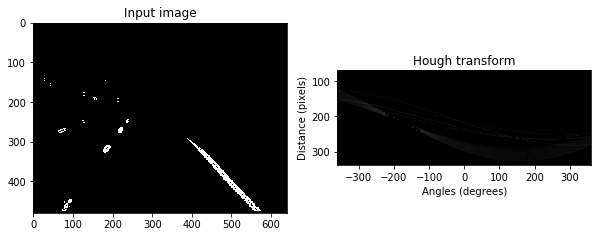

In [550]:
 show_hough_line(roi_test1, H, t, r)

In [551]:
new = test1.copy()
plotHoughPointLines(r,t,new)

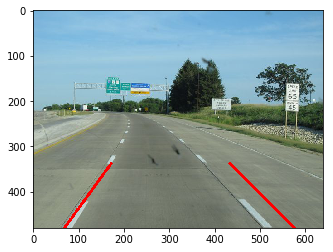

In [552]:
plt.imshow(new, cmap='gray')

In [575]:

QUEUE_LENGTH=50

class LaneDetector:
    def __init__(self):
        self.left_lines  = deque(maxlen=QUEUE_LENGTH)
        self.right_lines = deque(maxlen=QUEUE_LENGTH)

    def process(self, image):
        white_yellow = select_white_yellow(image)
        gray         = convert_gray_scale(white_yellow)
        padded_video = padding_func(gray, smoothing_kernel)  
        smoothed_video = smoothing(padded_video, gray, smoothing_kernel)
        a, b, c, d, e        = sobel(smoothed_video, 60, 3)
        regions      = select_region(e)
        H1, r1, t1 = hough_transform(regions)
        plotHoughPointLines(r1, t1, image) 
        return image

In [576]:
def process_video(video_input, video_output):
    detector = LaneDetector()
    clip = VideoFileClip(os.path.join('test_videos', video_input))
    processed = clip.fl_image(detector.process)
    processed.write_videofile(os.path.join('output_videos', video_output), audio=False)


In [ ]:
  process_video('challenge_kunal.mp4', 'cv_project_output.mp4')

[25.6, 712.8] [51.2, 21.599999999999998] [1267.2, 712.8] [768.0, 432.0]
(2937, 181)
[MoviePy] >>>> Building video output_videos/cv_project_output.mp4
[MoviePy] Writing video output_videos/cv_project_output.mp4








  0%|          | 0/68 [00:00<?, ?it/s]

[25.6, 712.8] [51.2, 21.599999999999998] [1267.2, 712.8] [768.0, 432.0]
(2937, 181)








  1%|▏         | 1/68 [02:42<3:01:48, 162.82s/it]

[25.6, 712.8] [51.2, 21.599999999999998] [1267.2, 712.8] [768.0, 432.0]
(2937, 181)








  3%|▎         | 2/68 [05:28<3:00:38, 164.22s/it]

[25.6, 712.8] [51.2, 21.599999999999998] [1267.2, 712.8] [768.0, 432.0]
(2937, 181)








  4%|▍         | 3/68 [08:00<2:53:21, 160.02s/it]

[25.6, 712.8] [51.2, 21.599999999999998] [1267.2, 712.8] [768.0, 432.0]
(2937, 181)








  6%|▌         | 4/68 [10:32<2:48:35, 158.05s/it]

[25.6, 712.8] [51.2, 21.599999999999998] [1267.2, 712.8] [768.0, 432.0]
(2937, 181)








  7%|▋         | 5/68 [12:54<2:42:40, 154.92s/it]